## CS 601 Project

A last ditch attempt for a course that should have had more assignments broken into smaller chunks.  But let's be honest, I still needed to pay more attention to deadlines, even though some things were not my fault.

### Date Set Chosen
     For this data set I have chosen a a wine quality survey with 14 features and 12,000 samples or 12 features and 14,000 samples. Either way,  it should meet the requirements.

### Purpose
    To build a random forsest from scratch. I reserve the right to  test the model later using sklearn's methods.


### Student Infomation
Lara Landis
CS601
Majid Ashfar
26 March 2025


In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from  matplotlib import pyplot as plt

rng = default_rng(110)
np.set_printoptions(precision=5, suppress=True)

## Step 1: Dataset Selection and Preprocessing

    Choose a suitable dataset that meets the above criteria.
    Download and load the dataset into your Python environment.
    Perform necessary preprocessing (handle missing values, encode categorical features, normalization/scaling, train-test split).


In [2]:
# We'll leave these here for later, but leave them commented out to avoid the temptation
# import sklearn.mettrics
# from sklearn.model import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# import sklearn.metrics

In [3]:
df = pd.read_csv("winequality-white.csv", sep=";")
# The reason for using the separator clause is because the white wine is 0.

In [4]:
# Explore the data some
df.fillna(0)     # Make sure there are no NaNs
df.shape

(4898, 12)

In [5]:
# Now we neeed to split our training data and our test data into different samples, this is one way to do this. We could
# also us sklearn.train_test_spllit.
train_data = df.iloc[0:int(np.floor(df.shape[0]* .65)), :]
test_data = df.iloc[int(np.floor(df.shape[0] * .65))+1:, :]
# Note, we actualy don't need to do any of this.
np.set_printoptions(precision = 5, suppress = True)   # No scientific notation, we don't need it.

In [6]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# Step 2: Implementing the Random Forest Classifier

    Implement a Random Forest classification algorithm entirely from scratch, without using pre-built libraries like Scikit-learn.
    Your implementation should allow specifying parameters, including:
            * Number of trees
            - Depth threshold
            - Number of samples per split 
            - Number of samples per leaf node
            - Criterion for determining the best feature split (Gini impurity or Entropy)
            - Optional: Any other parameter that you think could be interesting to add


### Bootstrap Samples

In [7]:
# This will produce our bootstrap sample for training. We start by  passing the data frame into it, creating a new list
# for sampled_data, and then we go through each sample, making assign a random column to the data. This should be different for
# each particular run.

def bootstrap(data):
    n_samples = data.shape[0] 
    sampled_data = []
    for i in range(n_samples):
        random_index = np.random.randint(0,n_samples)
        sampled_data.append(data[random_index])
    return np.array(sampled_data)

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### OOB Samples 
Selecting out of  bag will work similrly to the bootstrap process, but for this we want the ones not selected

In [9]:
# This function will create both the boot strap and the out of bg samples in one swoop. The first line creates
# the boostrap, it hen gets the nuber of unique lines, it creates a list to storte the samples in, and than it goes through
# each sample, then it looks to see if any item in the data sample currently being considered match 

def bs_oob_samples(data):
    bs = bootstrap(data)
    nuique_bs_samples = np.unique(bs, axis=0)
    oob_samples = []
    for sample in data:
        if sum(np.all(sample == nuique_bs_samples, axis= 1)) == 0:
            oob_samples.append(sample)
    return bs,np.array(oob_samples)

In [10]:
bs,oob = bs_oob_samples(df.to_numpy())   

In [11]:
bs

array([[ 6.7 ,  0.3 ,  0.35, ...,  0.54,  9.4 ,  6.  ],
       [ 6.8 ,  0.32,  0.39, ...,  0.35, 12.1 ,  6.  ],
       [ 5.4 ,  0.5 ,  0.13, ...,  0.88, 13.5 ,  7.  ],
       ...,
       [ 5.6 ,  0.34,  0.3 , ...,  0.49, 11.1 ,  6.  ],
       [ 7.8 ,  0.43,  0.49, ...,  0.35, 11.3 ,  6.  ],
       [ 8.2 ,  0.4 ,  0.48, ...,  0.52,  9.4 ,  5.  ]])

In [12]:
oob

array([[ 8.1 ,  0.22,  0.43, ...,  0.45, 11.  ,  6.  ],
       [ 6.6 ,  0.16,  0.4 , ...,  0.52, 12.4 ,  7.  ],
       [ 6.5 ,  0.31,  0.14, ...,  0.5 ,  9.5 ,  5.  ],
       ...,
       [ 6.2 ,  0.21,  0.29, ...,  0.5 , 11.2 ,  6.  ],
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ]])

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Note: It will be necessary to go back later and remove this part
def create_tree(data, max_depth = 3, min_samples_per_leaf = 5, criterion="gini"):
    X = data[:,0:-1]      # syphon the data we will use for predication features
    y = data[:,-1]        # set aside this for predictions
    dt = DecisionTreeClassifier()   # To be honest I'm not sure about using this, but it was used in the exmple code
    dt.fit(X,y)                     # Finally fit the data so we can make prediction
    return dt

In [14]:
dt = create_tree(bs)
dt

DecisionTreeClassifier()

In [15]:
oob.shape
bs.shape

(4898, 12)

In [16]:
print(dt.predict(oob[1:2, :-1]))  # Did we get the prediction?
print(oob[1:2, -1])

[7.]
[7.]


## Metric Used"

For now, gini impurity is being used.  This lets us know the chances that a random element is inorrect or as Victor Zhou states on his blog, "Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset." Personally, I feel like entropy would be a better choice on this because it would likely result in better results over all.

### Building the Random Forest

In [57]:
def sample_rf(data, depth =3, n_features = 10, leaf_nodes = 7, n_trees = 3):
    trees = []
    bs,oob = bs_oob_samples(data)
    for i in range(n_trees):
            # Get the last column and return it for evaluation
        n_features = bs.shape[1] - 1 # number of features excluding target col
        n_random_features = n_features        # For a small data set, we likely don't need this.
        random_selected_features =  rng.choice(n_features,n_random_features,replace = False)     # Select a new feature each time.                                                                                              # Replcae = False means new feature each time
        random_features_with_target = np.append(random_selected_features,-1) # add target index to selected features
        sub_data = bs[:,random_features_with_target]   # Create a subset of the bs samples
       
        dt = create_tree(sub_data, depth, leaf_nodes)                                            # Return the tree we need
        sub_oob = oob[:,random_selected_features] # Create a subset of the oob samples
        trees = dt.predict(sub_oob)         # Return the predictions since that is what we are interested in
    actual_values = oob[:, -1]
    # We need to return sub_oob for comparison
    return actual_values, trees

In [58]:
def forest_results(data, n_trees = 3):
    final_tree = []                                # Empty array to store the last tiems
    for i in range(len(data)):    
        acc = 0                                    # Set this to 0 after the start of outer loop because we need aavareages
        for j in range(n_trees):
            acc += data[i]
        final_tree.append(int(acc/n_trees))              # get the average and append it to the list

    return np.array(final_tree)                    # Return our tree as an numpy array for efficiency

In [59]:
actual_values, trained = sample_rf(bs,5, 7, 8)  ## Train the data set
results = forest_results(trained)           # Generate the actual random forest since the random forest function is lacking.
                                            # Note need to merge this into actual function or use it as a helper function

In [60]:
# Now that we've trained, let's see how it goes with our other data.actual_values, oob_preds = sample_rf(oob, 5, 7, 8)
trained_results = np.array(forest_results(trained, 7))
print(trained_results)
print(actual_values)

[6 6 6 7 7 7 5 6 5 5 5 7 6 5 7 7 6 6 7 6 4 6 6 8 7 5 6 6 6 8 5 7 6 6 8 4 6
 4 7 5 6 6 5 6 6 4 6 6 5 6 7 6 6 5 7 7 6 6 6 5 5 7 6 7 7 5 4 5 5 8 5 5 5 6
 6 6 6 5 7 5 6 6 6 6 6 5 6 7 7 7 6 6 8 6 6 6 6 6 7 6 7 6 6 6 6 5 5 5 7 5 5
 5 5 6 8 6 5 6 6 6 5 7 4 5 6 5 5 8 5 6 5 6 6 4 7 5 6 5 5 5 6 6 6 7 6 6 6 4
 6 6 6 6 6 5 6 7 6 8 6 6 7 5 6 7 7 6 6 7 7 6 8 6 8 8 5 6 6 6 4 5 6 6 5 6 6
 6 7 6 6 6 6 5 5 7 6 6 7 6 6 5 5 6 6 5 5 5 7 7 7 5 7 7 6 6 5 8 7 6 7 7 6 7
 7 5 6 6 6 6 6 7 7 7 5 6 5 8 7 7 6 7 6 5 5 6 5 5 6 6 5 7 6 4 6 5 6 5 5 7 5
 6 6 8 7 5 7 5 5 6 4 4 6 5 7 7 5 6 6 6 6 6 6 5 6 6 7 5 8 5 5 7 6 5 6 8 6 5
 6 6 7 7 9 6 5 5 7 6 5 5 5 7 6 5 4 6 5 5 4 6 5 7 8 6 7 5 7 7 6 5 6 7 6 6 7
 7 5 7 5 5 5 6 5 6 5 5 7 7 7 4 5 5 6 7 5 5 5 6 6 6 6 5 5 6 6 6 4 7 5 5 7 8
 6 7 4 7 5 5 7 7 6 7 5 6 5 6 4 6 5 6 5 7 7 7 5 6 7 8 6 6 7 6 7 6 5 9 8 5 5
 8 6 5 6 5 7 6 5 5 6 7 6 7 6 6 6 7 6 6 6 5 6 7 5 7 7 5 6 5 5 6 6 5 5 7 5 6
 6 5 5 5 5 6 7 5 6 7 6 5 6 5 6 6 6 6 7 5 5 6 6 8 7 6 6 6 6 6 6 6 5 7 7 7 5
 4 5 6 6 8 5 6 4 4 6 7 7 

In [61]:
oob[:, -1].shape

(1348,)

In [62]:
#  Now let's do wwhat we did with the trainign samples with the oob samples.
oob_actual, oob_preds = sample_rf(oob, 5, 7, 8)
oob_results = np.array(forest_results(oob_preds, 7))
print(len(oob_actual), len(oob_results))
print(oob_actual)
oob_results

465 465
[6. 7. 5. 6. 6. 7. 6. 6. 4. 5. 6. 7. 4. 6. 5. 5. 6. 5. 4. 7. 5. 7. 4. 5.
 5. 8. 4. 5. 5. 6. 7. 5. 6. 6. 5. 7. 5. 5. 6. 7. 6. 6. 5. 6. 6. 6. 6. 6.
 6. 6. 6. 5. 7. 7. 5. 6. 6. 5. 5. 4. 5. 7. 5. 5. 6. 5. 5. 5. 6. 6. 6. 6.
 7. 6. 7. 7. 7. 6. 7. 6. 6. 5. 6. 9. 6. 7. 4. 7. 6. 5. 5. 5. 4. 5. 7. 6.
 6. 4. 5. 6. 7. 5. 6. 5. 5. 7. 6. 6. 5. 7. 4. 8. 7. 7. 6. 5. 5. 4. 4. 6.
 6. 5. 5. 5. 7. 3. 7. 6. 7. 7. 5. 7. 6. 6. 6. 6. 7. 7. 6. 5. 5. 5. 6. 7.
 4. 7. 7. 7. 6. 3. 7. 6. 5. 6. 6. 6. 5. 5. 6. 5. 7. 5. 6. 7. 6. 6. 6. 4.
 6. 6. 5. 5. 7. 5. 5. 6. 7. 5. 6. 6. 5. 6. 6. 6. 6. 6. 6. 5. 6. 7. 5. 5.
 6. 6. 6. 5. 6. 5. 6. 4. 6. 5. 6. 5. 5. 6. 7. 6. 5. 6. 6. 5. 6. 6. 5. 5.
 6. 6. 6. 5. 5. 5. 5. 6. 4. 6. 7. 5. 7. 5. 5. 5. 5. 7. 6. 5. 5. 5. 5. 6.
 5. 6. 6. 7. 7. 6. 7. 6. 6. 6. 7. 5. 6. 4. 6. 5. 6. 5. 6. 6. 5. 5. 6. 7.
 5. 7. 5. 5. 6. 5. 5. 5. 4. 6. 6. 7. 5. 5. 7. 8. 8. 5. 7. 5. 5. 6. 5. 5.
 5. 5. 6. 7. 5. 7. 6. 6. 6. 6. 6. 5. 5. 7. 7. 5. 6. 7. 5. 6. 6. 6. 8. 6.
 5. 5. 5. 7. 6. 6. 5. 6. 6. 6. 7. 6. 6. 6. 

array([5, 6, 5, 7, 6, 5, 6, 5, 4, 7, 6, 6, 8, 7, 6, 6, 5, 5, 6, 7, 6, 7,
       5, 6, 6, 7, 5, 5, 6, 6, 6, 5, 7, 7, 6, 7, 6, 5, 5, 6, 5, 5, 6, 8,
       5, 8, 6, 7, 6, 5, 8, 5, 6, 6, 5, 6, 6, 6, 6, 5, 7, 7, 6, 6, 6, 6,
       5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 4, 5, 4, 6, 6, 5, 6, 7, 6, 6, 6, 5,
       6, 5, 6, 5, 4, 7, 6, 6, 7, 6, 7, 5, 5, 6, 6, 6, 5, 6, 4, 5, 5, 5,
       5, 6, 7, 6, 6, 6, 6, 5, 7, 5, 6, 5, 5, 5, 7, 6, 7, 5, 8, 8, 5, 6,
       6, 6, 6, 6, 6, 8, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 5, 5, 6, 6, 6, 7,
       6, 6, 6, 5, 7, 5, 8, 5, 6, 4, 6, 5, 6, 6, 6, 5, 6, 4, 6, 6, 7, 6,
       6, 6, 5, 7, 6, 6, 6, 5, 6, 6, 6, 5, 6, 5, 6, 5, 6, 6, 6, 5, 6, 6,
       8, 6, 5, 6, 4, 6, 5, 5, 6, 7, 6, 7, 6, 5, 6, 6, 5, 7, 6, 6, 6, 5,
       5, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 5, 5, 6, 6, 6, 5, 6, 6, 6, 7, 7,
       6, 7, 8, 6, 6, 7, 5, 7, 6, 5, 6, 5, 6, 6, 7, 6, 6, 7, 6, 5, 4, 6,
       5, 6, 5, 5, 7, 6, 6, 6, 6, 6, 5, 6, 3, 5, 6, 3, 3, 5, 5, 6, 6, 5,
       5, 7, 6, 5, 6, 7, 5, 5, 5, 6, 6, 4, 7, 6, 7,

# Step 3: Model Training, Evaluation, and Comparison

    Train your implemented classifier using your training dataset.
    Evaluate your model's performance on the test dataset using metrics such as accuracy, precision, recall, F1-score, and confusion matrix.
    Also, train a Random Forest classifier using Scikit-learn (sklearn.ensemble.RandomForestClassifier) on the same training dataset.
    Evaluate the Scikit-learn model's performance using the same metrics.
    Compare the performance of your implemented classifier with the Scikit-learn model and discuss any observed differences and insights.


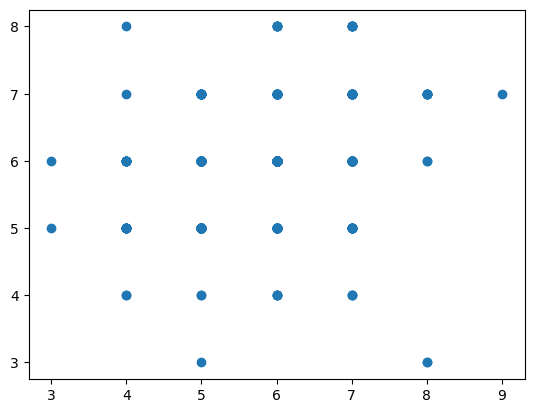

In [63]:
# Let's take a look at some data
plt.scatter(oob_actual , oob_results, label = "Diffrences between predictions and actual")
plt.show()

# The graph...
 
The graph's visualization isn't particularly helpful here. Let's take a look at some metrics to see how well oour classification
model performed. Some of these metrics may not make much sense in terms of wine quality, particularly false positives for this since we're
not classify between two things, but six. We'll look for accuracy, because the false positives and false negatives are meaningless on this set

## Formula for REcall
       TP/TP+FN of samples      (False negatives do not apply in this case.

In [64]:
results = oob_actual == oob_results
results

array([False, False,  True, False,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False,  True, False, False, False, False, False,
        True, False,  True, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False, False,
        True,  True,  True, False, False, False, False,  True, False,
       False,  True, False,  True,  True,  True, False, False, False,
       False,  True, False, False, False, False, False,  True,  True,
        True,  True, False,  True, False, False, False,  True,  True,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False, False,  True,  True,  True,  True,  True, False,
        True, False,

In [65]:
np.sum(np.any(results)==True)
# Okay, this isn't workiong like I want it to.
print(type(results))
# So let's do this the old fashioned way.
results.tolist()
counter = 0
true_positives = 0
true_negatives = 0
for item in results:
    if item == True:
        true_positives += 1
    if item == False:
        true_negatives += 1
    counter += 1
print (f'{true_positives / (true_positives + true_negatives)} =  {true_positives/counter}')  # Checking

<class 'numpy.ndarray'>
0.43010752688172044 =  0.43010752688172044


In [66]:
# Now that we have true positives versus the entire array, which will give us the same thing as (TP + TN)/(TP+TN+FP+FN)
# we can simplify are formula, since all negatives are true negatives and all positives are true positive, or should be for this 
# particular data set.

accuracy = true_positives / (true_positives + true_negatives)
accuracy * 100

43.01075268817204

## Evaluation`

Our model has around a 43% accuracy rating using 10 features, which is the highest accuracy rating of the run doing it from scratch. We know need to invoke scikit learn to compare our model to the model it would come up with
